In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import *

from qumcmc.classical_mcmc_routines import * 
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qulacs backend (**faster)
from QuantumSamplingRoutines_s import *
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics

import pickle, json 
import networkx as nx

#### helper func

In [2]:
class QuantumSamplingJob():

    def __init__(self, model: IsingEnergyFunction) -> None:
        self.model = model
        self.n_spins = model.num_spins
        
        self.quantum_circuit_id = 0

        self.transition_data = {}
        tdata = {}
        for state in states(self.n_spins):
            tdata[state] = 0.0
        for state in states(self.n_spins):
            self.transition_data[state] = tdata

        pass
    
    def sample_tranistion_matrix(self, gamma:float, time:float, delta_time:float= 0.8, num_shots:int= 1024, save_data= True, verbose= True, return_circuit:bool= False, return_data:bool= False ):
        
        initial_state = get_random_state(self.n_spins)
        qc_initialised_to_s = initialise_qc(self.model.num_spins, initial_state)
        
        num_trotter_steps = int(np.floor((time / delta_time)))
        qc_evol_h1 = fn_qc_h1(self.n_spins, gamma, self.model.alpha, self.model.h, delta_time)
        qc_evol_h2 = fn_qc_h2(self.model.J, self.model.alpha, gamma, delta_time=delta_time)
        trotter_ckt = trottered_qc_for_transition(
            self.n_spins, qc_evol_h1, qc_evol_h2, num_trotter_steps=num_trotter_steps
        )
        qc_for_mcmc = combine_2_qc(qc_initialised_to_s, trotter_ckt)# i can get rid of this!

        if return_circuit:    return qc_for_mcmc
        # run the circuit
        q_state=QuantumState(qubit_count=self.n_spins);q_state.set_zero_state()
        qc_for_mcmc.update_quantum_state(q_state)
        states_obtained= q_state.sampling(sampling_count= num_shots)
        
        # states_obtained_binary= DiscreteProbabilityDistribution(Counter([f"{state_obtained:0{self.n_spins}b}" for state_obtained in states_obtained if state_obtained in self.transition_data.keys()]))
        states_obtained_binary= DiscreteProbabilityDistribution(Counter([f"{state_obtained:0{self.n_spins}b}" for state_obtained in states_obtained]))
        assert sum(states_obtained_binary.values()) == 1.0 , 'norm err'

        ##@check
        for k in states_obtained_binary.keys(): assert len(k) == self.n_spins , "something wrong"

    
        tdata = self.transition_data[initial_state]
        for k in states_obtained_binary.keys():
            tdata[k] = (tdata[k] + states_obtained_binary[k])  
            # assert sum(tdata.values()) == 1 , 'norm err' 
            
        print(sum(tdata.values())), print(tdata)
        tdata = DiscreteProbabilityDistribution(tdata); tdata._normalise(print_normalisation= True)
        assert np.abs(sum(tdata.values()) - 1.0) < 0.0001 , 'norm err' 
        self.transition_data[initial_state] = tdata
            
 
        if save_data: 
            # self.quantum_circuit_id += 1
            name =  self.model.name + '.pickle'; assert isinstance(name, str)
            with open('DATA/transition-data/'+ name, 'wb') as handle:
                pickle.dump(self.transition_data, handle)
       

In [3]:
def build_matrix_from_dict(dict: dict):
    n = len(dict.keys())

    matrix = np.zeros((n,n), dtype= float)

    for k1 in dict.keys():
        for k2 in dict[k1].keys():

            matrix[int(k1, 2)][int(k2, 2)] = dict[k1][k2]

    return matrix
def build_dict_from_matrix(matrix:np.array):
    n = matrix.shape[0]

    dict = {}
    for k1 in range(n):
        
        z  = np.sum(matrix[k1])
        dict_tmp = {}
        for k2 in range(n):
            dict_tmp[k2] = matrix[k1][k2] / z
        
        dict[k1] = dict_tmp
    
    return dict

def build_mcmc_from_transition_dict(
    n_hops: int,
    model: IsingEnergyFunction,
    transition_dict: dict,
    initial_state: Optional[str] = None,
    temperature: float = 1.,
    verbose:bool= False
):
    """
    ARGS:
    -----
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model:
    return_last_n_states: (int) Number of states in the end of the M.Chain you want to consider for prob distn (default value is last 500)
    return_both (default=False): If set to True, in addition to dict_count_return_lst_n_states, also returns 2 lists:
                                "list_after_transition: list of states s' obtained after transition step s->s' " and
                                "list_state_mchain_is_in: list of states markov chain was in".
    RETURNS:
    --------
    Last 'dict_count_return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it!
    
    """
    num_spins = model.num_spins

    if initial_state is None : 
        initial_state = MCMCState(get_random_state(num_spins), accepted=True)
    else:
        initial_state = MCMCState(initial_state, accepted=True)
    
    current_state: MCMCState = initial_state
    energy_s = model.get_energy(current_state.bitstring)
    if verbose : print("starting with: ", current_state.bitstring, "with energy:", energy_s)

    mcmc_chain = MCMCChain([current_state])


    for _ in tqdm(range(0, n_hops), desc= 'running MCMC steps ...', disable= not verbose):
        # get sprime
        t_dict = DiscreteProbabilityDistribution(transition_dict[current_state.bitstring])
        s_prime =  np.random.choice(list(t_dict.keys()), size= 1, 
                                  p = list(t_dict.values()))[0]
        
        # accept/reject s_prime
        energy_sprime = model.get_energy(s_prime)   # to make this scalable, I think you need to calculate energy ratios.
        accepted = test_accept(
            energy_s, energy_sprime, temperature=temperature
        )
        mcmc_chain.add_state(MCMCState(s_prime, accepted))
        if accepted:
            current_state = mcmc_chain.current_state
            energy_s = model.get_energy(current_state.bitstring)
        
    return mcmc_chain


In [4]:
def build_energy_function_from_graph(graph: nx.Graph, name:str = 's'):
    
    nspins = graph.number_of_nodes()
    j = nx.get_edge_attributes(graph, 'J')
    J = np.zeros((nspins, nspins))

    for edge in graph.edges():
        J[edge[0], edge[1]] = j[edge]
        J[edge[1], edge[0]] = j[edge]

    H = np.array(list(nx.get_node_attributes(graph, 'h').values()))

    return IsingEnergyFunction(J =J, h=H, name= name)

#### DEFINE MODEL

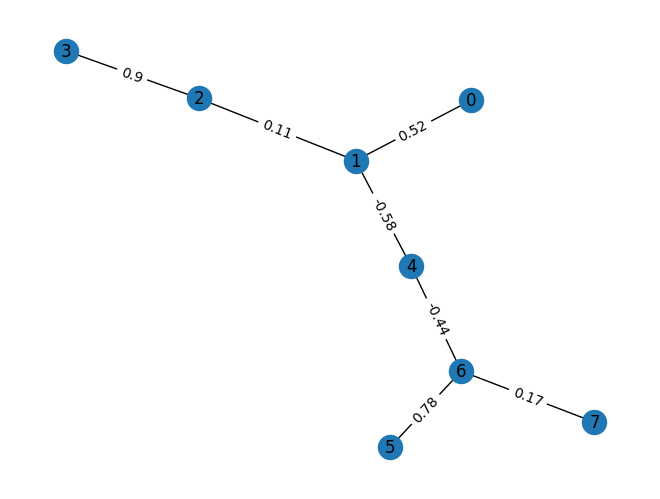

In [5]:
# node_to_qubit_map = {0: 0, 1:1, 2:2, 3:3, 4:4, 5:6, 6:7, 7: 10}
# qubit_to_node_map = dict([(item[1], item[0]) for item in node_to_qubit_map.items()])

# map_node_to_qubit = lambda x: node_to_qubit_map[x]
# map_qubit_to_node = lambda x: qubit_to_node_map[x]

# device_nodes = [0,1,2,3,4,6,7,10]
# device_edges = [(0,1),(1,4),(4,7),(7,10),(7,6),(1,2),(2,3)]

# graph_nodes = [0,1,2,3,4,5,6,7]

# graph_edges = []
# for edge in device_edges:
#     i = map_qubit_to_node(edge[0])
#     j = map_qubit_to_node(edge[1])
#     new_edge = (i,j)
#     graph_edges.append(new_edge)
    
# trial_graph = nx.Graph(name= "ising_1")
# trial_graph.add_nodes_from(graph_nodes)
# trial_graph.add_edges_from(graph_edges)

# h = [0.1, 0.3, 0.4, 0.21, 0.38, 0.15, 0.25, 0.10]
# node_attr = {}
# for index, node in enumerate(trial_graph.nodes) :

#     node_attr[node] = {'h': np.round(h[index] * np.random.choice([1, -1]), 2)}

# nx.set_node_attributes(trial_graph, node_attr)
# edge_attr = {}
# for edge in trial_graph.edges :
#     edge_attr[edge] = {'J': np.round(np.random.uniform(-1,1),2)}
# nx.set_edge_attributes(trial_graph, edge_attr)



with open('DATA/model-data/ising_exp.pkl', 'rb') as hl :
     trial_graph =  pickle.load(hl)


pos = nx.spring_layout(trial_graph)
nx.draw(trial_graph, pos, with_labels= True,)
nx.draw_networkx_edge_labels(trial_graph, pos, edge_labels= nx.get_edge_attributes(trial_graph, 'J'));

            MODEL : ising_exp
Non-zero Interactions (J) : 7 / 28
Non-zero Bias (h) : 8 / 8
---------------------------------------------
Average Interaction Strength <|J|> :  0.109375
Average Bias Strength <|h|>:  0.23625000000000002
alpha :  1.689313314394678
---------------------------------------------


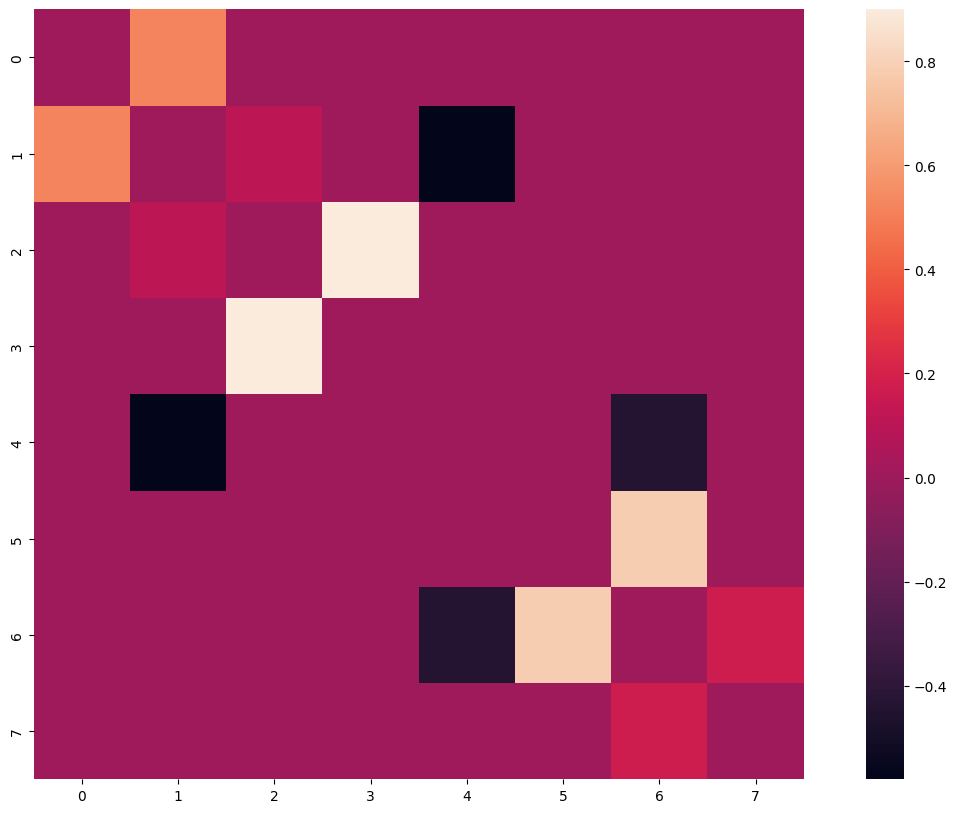

In [6]:
model = build_energy_function_from_graph(trial_graph, name= 'ising_exp')
model.model_summary()

In [7]:
# with open('DATA/model-data/'+model.name+'.pkl', 'wb') as hl:
#     pickle.dump(trial_graph, hl)

Running Exact Sampling | beta :  1.85


running over all possible configurations: 100%|██████████| 256/256 [00:00<00:00, 159285.24it/s]

saving distribution to model ...
     MODEL : ising_exp |  beta : 1.85
Num Most Probable States : 19
Entropy : 4.233242821254769
---------------------------------------------


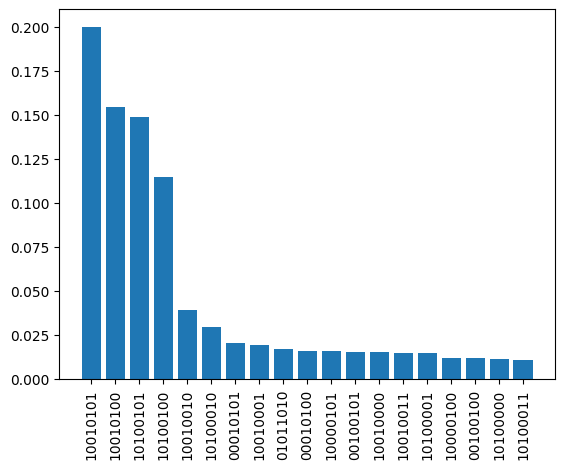

In [8]:
## exact sample model
beta = 1.85; temperature = 1 / beta

esm_model = Exact_Sampling(model, beta= beta, verbose= True)

esm_model.sampling_summary()

#### DEFINE SAMPLING ROUTINE

In [9]:
# sampling_job = QuantumSamplingJob(model)
# gamma_values = list(np.linspace(0.26,0.6,9) )
# time_values = 0.8 * np.arange(2,12)
# # gamma_values = np.linspace(0.26,0.6,9) ;
#   ## 9x10 circuits = 90, times 3 for SPAM twirling
# all_params = []
# for gamma in gamma_values:
#     for time in time_values:
#         all_params.append((gamma,time))

# for gamma,time in all_params:
#   sampling_job.sample_tranistion_matrix(gamma, time, num_shots= 2**(model.num_spins))

In [10]:
with open('DATA/transition-data/sm1.pickle', 'rb') as hl:
    transition_dict = pickle.load(hl)

<AxesSubplot: >

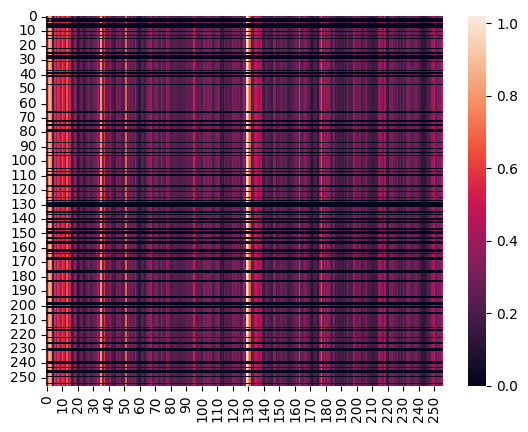

In [11]:
mx = build_matrix_from_dict(transition_dict)
import seaborn as sns

sns.heatmap(mx)

#### plots

In [12]:
qchain_0 = build_mcmc_from_transition_dict(5000, esm_model, transition_dict, temperature= temperature, verbose= True)
cchain = classical_mcmc(5000, esm_model,temperature= temperature, verbose=True)
qchain_1 = quantum_enhanced_mcmc(5000, model, temperature= temperature, verbose= True)

starting with:  00010101 with energy: -3.0100000000000002


running MCMC steps ...: 100%|██████████| 5000/5000 [00:00<00:00, 11093.89it/s]


starting with:  00000100 with energy: -1.4900000000000002


running MCMC steps ...: 100%|██████████| 5000/5000 [00:00<00:00, 126127.79it/s]


starting with:  01110111 with energy: 3.59


runnning quantum MCMC steps . ..: 100%|██████████| 5000/5000 [00:04<00:00, 1180.68it/s]


In [13]:
qtrj_1 = get_trajectory_statistics(qchain_1, esm_model, verbose=False)
qtrj_0 = get_trajectory_statistics(qchain_0, esm_model, verbose=False)
ctrj = get_trajectory_statistics(cchain, esm_model, verbose=False)

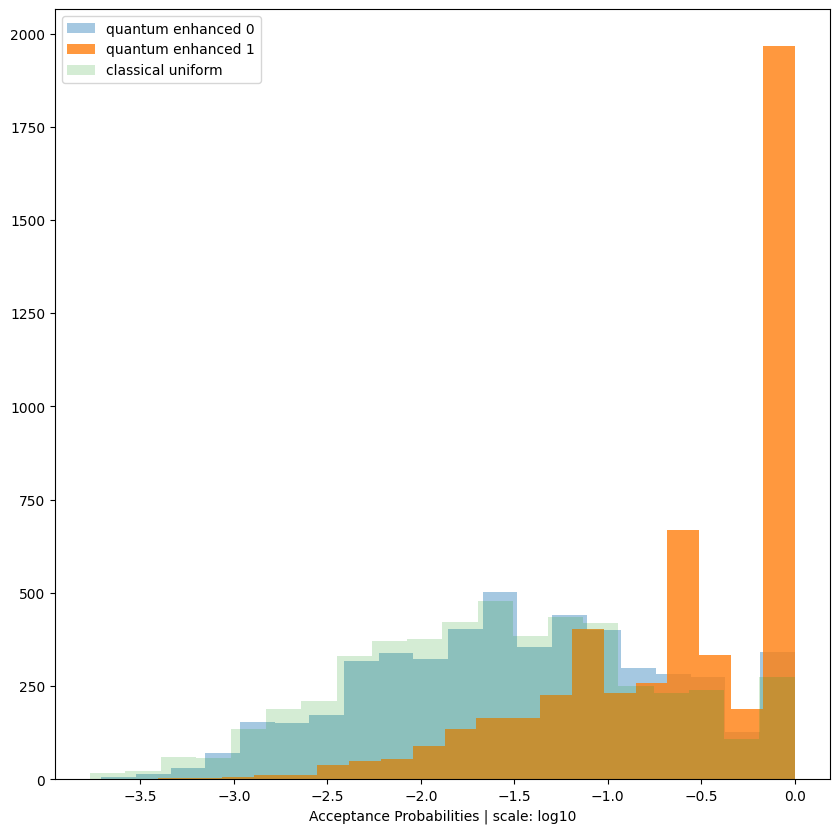

In [14]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(qtrj_0['acceptance_prob']),label= 'quantum enhanced 0' , alpha= 0.4, bins= 20)
plt.hist(np.log10(qtrj_1['acceptance_prob']),label= 'quantum enhanced 1' , alpha= 0.8, bins= 20)
plt.hist(np.log10(ctrj['acceptance_prob']),label= 'classical uniform' ,alpha= 0.2, bins= 20)


# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

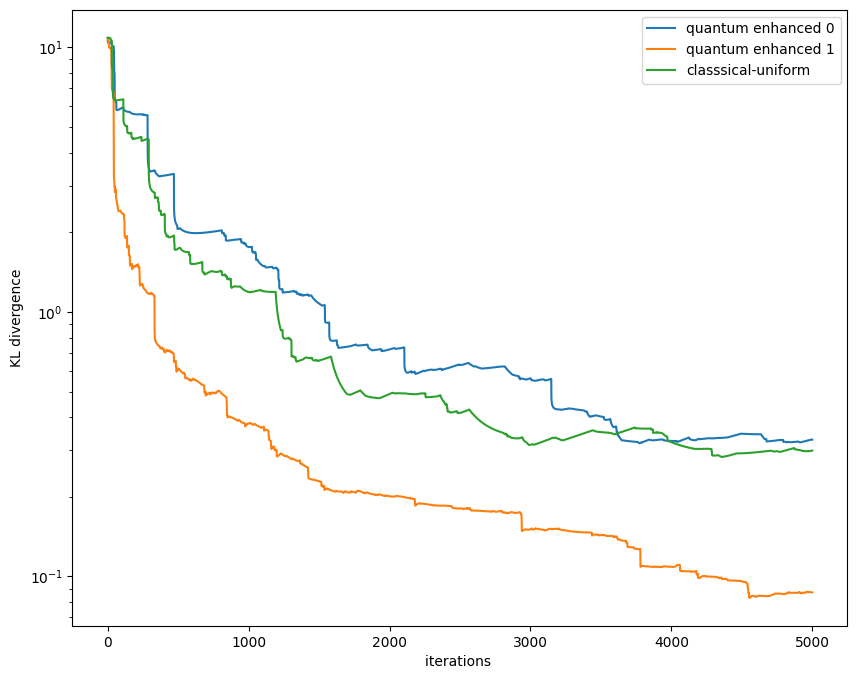

In [15]:
plt.figure(figsize=(10,8))
# plt.plot(jsdiv_c, label= 'classical')
plt.plot(qtrj_0['kldiv'], label= 'quantum enhanced 0')
plt.plot(qtrj_1['kldiv'], label= 'quantum enhanced 1')
plt.plot(ctrj['kldiv'], label= 'classsical-uniform')
plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()


In [18]:
magnetization_model = esm_model.get_observable_expectation(magnetization_of_state)
magnetization_c = calculate_runnning_magnetisation(cchain)
magnetization_q_0 = calculate_runnning_magnetisation(qchain_0)
magnetization_q_1 = calculate_runnning_magnetisation(qchain_1)


100%|██████████| 5000/5000 [00:00<00:00, 10170.76it/s]


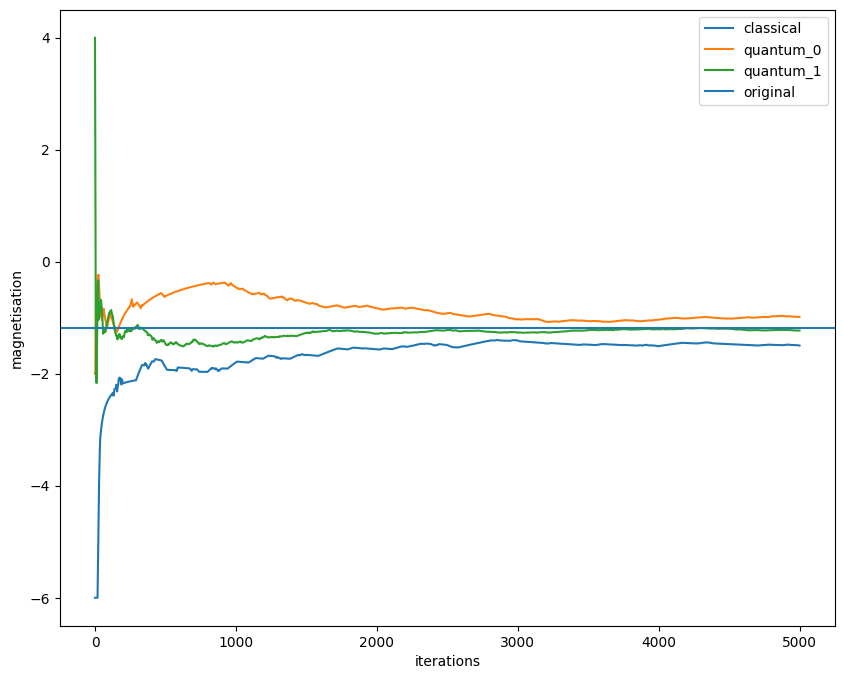

In [19]:

plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical')
plt.plot(magnetization_q_0, label= 'quantum_0')
plt.plot(magnetization_q_1, label= 'quantum_1')
plt.axhline(magnetization_model, label= 'original')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()